# **Place of birth analysis**

In this notebook, we will analyze the places of birth and sites of study by the realization of maps. It is another way to represent the data. We will present two ways to make it: one with the geographic coordinates and one with polygons. 

Documentation: 
* [Geographic information system](https://en.wikipedia.org/wiki/Geographic_information_system) (Wikipedia - en)
* [Geoid](https://en.wikipedia.org/wiki/Geoid)

In [2]:
# import libraries
# geopandas is a library used to work with geospatial data.
# cf. https://geopandas.org/
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mapclassify

import numpy as np

In [3]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

In [4]:
# This library can make interactions like range sliders. 
# cf. https://ipywidgets.readthedocs.io/en/latest/index.html
from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple,
    SelectionRangeSlider, Layout,
    jslink, fixed,
    HTML, HBox)

In [5]:
# this library is used to achieve interactive maps b
# documentation: https://ipyleaflet.readthedocs.io/en/latest/
from ipyleaflet import (Map,
                        Polygon,
                        GeoData,
                        Marker,
                        basemap_to_tiles,
                        basemaps,
                        CircleMarker,
                        MarkerCluster,
                        LayerGroup, 
                        LayersControl,
                        WidgetControl,
                        Popup,
                        ScaleControl
                       )

In [5]:
import sparql_functions as spqf

In [6]:
### It's define the database ligne to use
pk_query = 44

# Connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

c = conn.cursor()

### It runs the query on the SQLite database to get the row values 
c.execute('SELECT * FROM query WHERE pk_query = ?', [pk_query]) ### a list around argument is needed for a string longer then one
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchone()

# close connexion
conn.close()


In [7]:
print("\033[1mDescription:\033[0m\n\n"+rc[3]  + "\n-----\n" +"\033[1mDatabase:\033[0m\n\n"+ rc[2]+  "\n----\n"+"\033[1mNotes:\033[0m\n\n" +rc[7] + "\n----\n"+"\033[1mTime stamp:\033[0m\n\n"+rc[8]+  "\n--------------\n" +"\033[1mSparl endpoint:\033[0m\n\n"+   rc[5] + "\n-----------\n" +"\033[1mQuery:\033[0m\n\n"+ rc[6])

Description:

SELECT: In this query, we will analyze the place of birth of the individuals and we will realise some maps.
-----
Database:

Wikidata
----
Notes:

 
----
Time stamp:

2021-07-05 09:41:53
--------------
Sparl endpoint:

http://localhost:7200/repositories/IMPORT
-----------
Query:

PREFIX  wikibase: <http://wikiba.se/ontology#>
PREFIX  wd:   	  <http://www.wikidata.org/entity/>
PREFIX  wdt:  	  <http://www.wikidata.org/prop/direct/>
PREFIX  rdfs: 	  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX  owl:      <http://www.w3.org/2002/07/owl#>
PREFIX  rdf:      <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  xsd:      <http://www.w3.org/2001/XMLSchema#>

SELECT  ?person ?name  ?occupation ?year ?birthPlace  ?type ?long ?lat
WHERE{ {
SELECT  ?person ?name ?occupation (ROUND(AVG(?birthDate_avg)) AS ?year) ?birthPlace  ?long ?lat ?type
    WHERE { {
    SELECT Distinct ?person ?nameLabel (GROUP_CONCAT(DISTINCT(?occLabel); SEPARATOR = "|") AS ?occupation1) ?gender  ?nationalit

In [85]:
### Execute the SPARQL query wrapped in the function in the library _sparql_functions.py_
# The first setting correspond to SPARQL Endpoint, the seconde to the query
q = spqf.get_json_sparql_result(rc[5],rc[6])

<class 'dict'>


In [86]:
##### Transform the result into a list with a fonction of the library #####
#### Result of the query
r_query = [l for l in spqf.sparql_result_to_list(q)]
print(len(r_query))
#r_query

99810


In [87]:
### Create a dataframe
df_places = pd.DataFrame(r_query)
df_places.columns =['id_entity', "name", "occupation", "year", "birthPlace", "type", "long" ,"lat"]
df_places[:15]

,id_entity,name,occupation,year,birthPlace,type,long,lat
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,Stephen Harper,economist,1959,Toronto,city,-79.386666666667,43.670277777778
1,urn:uuid:5c7f3133-a15b-4f35-8e17-162cf63207f7,Abraham Lincoln,jurist,1809,Hodgenville,,-85.738611111111,37.571111111111
2,urn:uuid:92ebbd17-f4d1-4cdd-816c-5fcf4ba34dce,Wiltraut Rupp-von Brünneck,jurist|jurist,1912,Lankwitz,,13.35,52.4333
3,urn:uuid:9ce56c33-08da-497c-afb0-38cb6ff6536c,Joseph C. O'Mahoney,jurist,1884,Chelsea,,-71.033333333333,42.391666666667
4,urn:uuid:2178758f-d8df-447d-b64b-bd78dfe045b7,Valentyn Symonenko,economist,1940,Odessa,,30.73262,46.47747
5,urn:uuid:490ab506-b377-4e39-bf39-3d6e3f732a62,"Hugh Meade Alcorn, Jr.",jurist,1907,United States of America,,-98.5795,39.828175
6,urn:uuid:8b81cd5a-63af-4905-817e-9dcea33ae252,Wolfgang Poppelbaum,jurist,1939,Vienna,,16.373064,48.20833
7,urn:uuid:0a98b4ed-2ecf-4a4f-8250-e405279d4f64,Alexander Eisvogel,jurist,1965,Mechernich,,6.65,50.6
8,urn:uuid:13dbca6a-92fc-4582-8d38-796577b4c0d0,Gejza Ferdinandy,jurist|jurist,1864,Košice,city,21.25,48.716666666667
9,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,Bud Cullen,jurist|jurist,1927,Walden,,-81.334,46.358


In [88]:
### We encode to obtain of three types: "jurist", "economist" and "jurist/economist"  
## ( In the SPARQL query, a concatenation of the type has been processed cf. SQLite: query n°44)
df_places['occupation'].replace(["jurist|jurist", "jurist|jurist|jurist", "jurist|jurist|jurist|jurist", "legal jurist in France", "jurist|legal jurist in France"],'jurist',inplace=True)
df_places['occupation'].replace(["jurist|jurist|economist", "jurist|jurist|jurist|economist", "jurist|jurist|jurist|jurist", "jurist|economist|jurist", "economist|jurist", "jurist|economist"],'jurist/economist',inplace=True)


In [89]:
df_places.to_csv("spreadsheets/Maps/df_places.csv", sep="|")

In [40]:
df_places=pd.read_csv("spreadsheets/Maps/df_places.csv", sep="|", index_col=0)

In [41]:
### Group data by place type and count them
gb_places = pd.DataFrame(df_places.groupby('type').size())
gb_places.columns = ['freq']
gb_places.sort_values(by='freq', ascending=False)

,freq
type,
city,20741
capital,12859
town,2072
city/town,1786
global city,995
megacity,798
village,782
suburb,144
urban area,53


In [42]:
### Group data by place type (can have several types for one place) and count them per group
## Inspects types: which ones keep ? 
types_places = df_places.fillna(value='').groupby(['id_entity'])['type'].apply(','.join).reset_index()
gb_types_places = pd.DataFrame(types_places.groupby('type').size())
gb_types_places.columns = ['eff']
gb_types_places.sort_values(by='eff', ascending=False).head(10)

,eff
type,
,45993
city,10093
capital,5142
"capital,city",4726
",",2369
",,,",1414
town,1296
"city,city",976
"city,global city",854


In [45]:
# Construct a column with propertyes of the places grouped as a list (create a list for each place)
df_places['place_list'] = df_places[['birthPlace','type','long','lat']].apply(lambda x: list(x), axis=1)
df_places.head()

,id_entity,name,occupation,year,birthPlace,type,long,lat,place_list
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,Stephen Harper,economist,1959,Toronto,city,-79.386667,43.670278,"[Toronto, city, -79.386666666667, 43.670277777..."
1,urn:uuid:5c7f3133-a15b-4f35-8e17-162cf63207f7,Abraham Lincoln,jurist,1809,Hodgenville,NaN,-85.738611,37.571111,"[Hodgenville, nan, -85.738611111111, 37.571111..."
2,urn:uuid:92ebbd17-f4d1-4cdd-816c-5fcf4ba34dce,Wiltraut Rupp-von Brünneck,jurist,1912,Lankwitz,NaN,13.350000,52.433300,"[Lankwitz, nan, 13.35, 52.4333]"
3,urn:uuid:9ce56c33-08da-497c-afb0-38cb6ff6536c,Joseph C. O'Mahoney,jurist,1884,Chelsea,NaN,-71.033333,42.391667,"[Chelsea, nan, -71.03333333333299, 42.39166666..."
4,urn:uuid:2178758f-d8df-447d-b64b-bd78dfe045b7,Valentyn Symonenko,economist,1940,Odessa,NaN,30.732620,46.477470,"[Odessa, nan, 30.73262, 46.477470000000004]"


In [46]:
# Group places of birth per person by a new dataframe
## All places as a list produce above are together
l_birthPlace = df_places.groupby(['id_entity', 'name']).agg({'place_list': lambda x: list(x), 'year': lambda x: max(x)}).reset_index()
l_birthPlace.head()

,id_entity,name,place_list,year
0,urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,Shōji Tanaka,"[[Tokyo, capital, 139.69222222222, 35.68972222...",1924
1,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,Andrej Ferjančič,"[[Slap, nan, 13.933333, 45.839166999999996]]",1848
2,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,Helene White,"[[Jackson Heights, nan, -73.886944, 40.751389]]",1954
3,urn:uuid:0003a60a-43e0-4f10-b6a2-ccec94311b09,Ernest Boulanger,"[[Nantillois, nan, 5.1391666666667, 49.2988888...",1831
4,urn:uuid:00051051-28de-44cf-9d2b-769dd57f5e96,Gregory Fajt,"[[Greensburg, nan, -79.54222222222201, 40.2977...",1954


In [67]:
### Drop places multiples for a person by focusing capitals, then cities, then town, etc.
## With 'for', this browses in the order of the important types
# if the variable 'i_birthPlace' has a place, his lentgh is not equal to 0 and this go out the loop
# otherwise, this choose the next place of birth, etc.

unique_birthPlace = []
for l in l_birthPlace.to_records():
    
    i_birthPlace = []
    if len(i_birthPlace) == 0:
        for i in l[3]:
            if i[1] == 'capital':
                i_birthPlace = i
            elif i[1] == 'city':
                i_birthPlace = i
            elif i[1] == 'town':
                i_birthPlace = i
            elif i[1] == 'city/town':
                i_birthPlace = i
            elif i[1] == 'village':
                i_birthPlace = i
    else:
        pass
    if len(i_birthPlace) == 0:
        i_birthPlace = l[3][0]
    unique_birthPlace.append([l[1]] + [l[2]]+ i_birthPlace + [int(l[4]) if str(l[4]) > '' else 2020])


print(len(unique_birthPlace))
unique_birthPlace[:2]

77429


[['urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11',
  'Shōji Tanaka',
  'Tokyo',
  'capital',
  139.69222222222,
  35.689722222222,
  1924],
 ['urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919',
  'Andrej Ferjančič',
  'Slap',
  nan,
  13.933333,
  45.839166999999996,
  1848]]

In [68]:
df_ubp = pd.DataFrame(unique_birthPlace)
df_ubp.columns = ['id_entity','name','birthPlace','type','long','lat', 'year']
print(len(df_ubp))
df_ubp.head()

77429


,id_entity,name,birthPlace,type,long,lat,year
0,urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,Shōji Tanaka,Tokyo,capital,139.692222,35.689722,1924
1,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,Andrej Ferjančič,Slap,NaN,13.933333,45.839167,1848
2,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,Helene White,Jackson Heights,NaN,-73.886944,40.751389,1954
3,urn:uuid:0003a60a-43e0-4f10-b6a2-ccec94311b09,Ernest Boulanger,Nantillois,NaN,5.139167,49.298889,1831
4,urn:uuid:00051051-28de-44cf-9d2b-769dd57f5e96,Gregory Fajt,Greensburg,NaN,-79.542222,40.297778,1954


In [69]:
### Check if there is a place of birth per individual
gb_df_ubp= df_ubp.groupby(['id_entity']).size()
print("More than one place : " + str(len(gb_df_ubp[gb_df_ubp > 1])))
print("No place : " + str(len(gb_df_ubp[gb_df_ubp == 0])))
print("Individuals with one place of birth : " + str(len(gb_df_ubp[gb_df_ubp == 1])))
df_ubp.head()

More than one place : 0
No place : 0
Individuals with one place of birth : 77429


,id_entity,name,birthPlace,type,long,lat,year
0,urn:uuid:0000604d-91f6-4680-9ed9-4a9cd345af11,Shōji Tanaka,Tokyo,capital,139.692222,35.689722,1924
1,urn:uuid:00033b44-dea6-4a45-bd42-c4995e5e3919,Andrej Ferjančič,Slap,NaN,13.933333,45.839167,1848
2,urn:uuid:00034d59-7ac8-4638-a0e9-af297e6ec3c0,Helene White,Jackson Heights,NaN,-73.886944,40.751389,1954
3,urn:uuid:0003a60a-43e0-4f10-b6a2-ccec94311b09,Ernest Boulanger,Nantillois,NaN,5.139167,49.298889,1831
4,urn:uuid:00051051-28de-44cf-9d2b-769dd57f5e96,Gregory Fajt,Greensburg,NaN,-79.542222,40.297778,1954


### Inspect the birth distribution

[1770, 1771, 1772, 1773, 1774]


<BarContainer object of 230 artists>

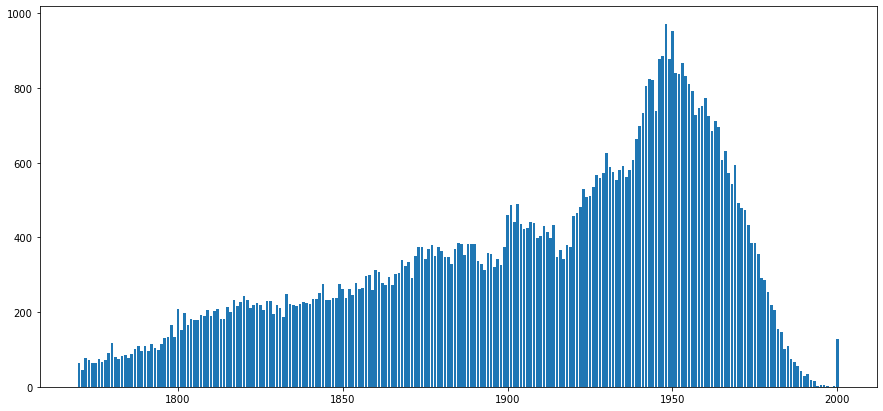

In [70]:
gb_years_birth = df_ubp.groupby(['year']).size()


objects = [l for l in gb_years_birth.index]
eff = [l for l in gb_years_birth]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.bar(objects, eff)

## **Add activity periods** 

We cut by activity periods corresponding to world history.

Activity periods: -1900 (before XXth century), 1901-1945 (both World Wars period), 1946- (contemporary period)

In addition, we can imagine ranges for the activity period 
:
* min: birth + 25 years
* max: birth + 75 years

In [71]:
### Fonction to add the activity period

# several activity periods are possible for the same person
def activity_period(birth_year):    
    period_value = []
    if (birth_year + 25) < 1901:
        period_value.append("-1900")        
    # The second clause excludes people probably who no longer works even if born before the indicated date.
    if (birth_year + 75) > 1900 and (birth_year + 25) < 1946:
        period_value.append("1901-1945")
    if (birth_year + 75) > 1945:
        period_value.append("1946-")
    return period_value


In [72]:
activity_period(1860), activity_period(1873), activity_period(1900)

(['-1900', '1901-1945'],
 ['-1900', '1901-1945', '1946-'],
 ['1901-1945', '1946-'])

In [73]:
# Apply the activity period to the persons with the activity_period function
df_ubp['activity_period'] = df_ubp['year'].apply (lambda x : activity_period(x))

In [74]:
# Prepare data used after in the map
df_ubp['concat_person'] = df_ubp['id_entity'] + '|'  + df_ubp['name']+ '|' + df_ubp['year'].apply (lambda x : ' (' + str(x) + ')' )

In [75]:
##### Group per place of birth
## Add the number of individual per place of birth and the activity periods of the individuals
# cf. https://izziswift.com/naming-returned-columns-in-pandas-aggregate-function/
# The 'as_index' option should be marked as false but this didn't work.
place_count = df_ubp.groupby(['birthPlace', 'type', 'long', 'lat'], as_index=True) \
      .agg(persons = ('concat_person', ','.join), frequency=('id_entity', 'count'),\
       periods = ('activity_period', 'sum')).sort_values(by=['birthPlace'])
print(len(place_count))
place_count[130:135]

3813


,,,,persons,frequency,periods
birthPlace,type,long,lat,,,
Aplao,city,-72.500000,-16.083333,urn:uuid:c934e0a6-de27-4e14-b75a-01a818c7fbea|...,1,[-1900]
Appenzell,village,9.408611,47.330556,urn:uuid:918dd2b2-3bad-4b2c-a3b0-f76bcea62089|...,1,"[-1900, 1901-1945]"
Aracaju,capital,-37.050000,-10.916700,urn:uuid:062c60e0-8f7f-4295-944d-0b2690b7da82|...,18,"[1946-, 1946-, -1900, 1901-1945, 1901-1945, 19..."
Arachova,town,22.586667,38.478889,urn:uuid:41f2062d-201b-430c-9372-b4df959a57b5|...,1,"[1901-1945, 1946-]"
Araci,village,25.653618,45.806686,urn:uuid:0b9b802c-48d8-4be6-9d79-539bfcb98c67|...,1,[1946-]


In [76]:
# Reset index 
place_count=place_count.reset_index()

In [77]:
### Aggregate and count periods
## A person can be in more than one period
place_count['aggregate_periods'] = place_count['periods'].apply(lambda x : dict(Counter(x)))

In [78]:
# Example: Paris
place_count[place_count['birthPlace'] == 'Paris']

,birthPlace,type,long,lat,persons,frequency,periods,aggregate_periods
2516,Paris,capital,2.351389,48.856944,urn:uuid:01121c51-5aeb-41ff-b9e6-f2f16bdb0a91|...,508,"[1946-, 1901-1945, 1946-, 1946-, 1901-1945, 19...","{'1946-': 289, '1901-1945': 220, '-1900': 226}"


In [79]:
# Save dataframe
place_count.to_csv('spreadsheets/Maps/birth_place_years.csv', sep=';')

In [80]:
place_count = pd.read_csv('spreadsheets/Maps/birth_place_years.csv', sep=';', index_col=[0])
place_count.iloc[100:110]
#print(len(place_count))

,birthPlace,type,long,lat,persons,frequency,periods,aggregate_periods
100,Ammanford,town,-3.993000,51.800000,urn:uuid:1979abdf-bf9a-4747-bff6-64512ce5bb92|...,2,"['1946-', '1946-']",{'1946-': 2}
101,Amoudah,city,40.930000,37.104167,urn:uuid:fe4e4d6d-ee1c-4be9-86fe-fdc581628432|...,1,['1946-'],{'1946-': 1}
102,Amravati,city,77.750000,20.933333,urn:uuid:f68ced86-5315-44fc-bd67-94ddc79da5d6|...,1,['1946-'],{'1946-': 1}
103,Amritsar,city,74.877040,31.626917,urn:uuid:0ec6e130-e67e-47e0-9b68-418529748153|...,6,"['1901-1945', '1946-', '1946-', '1901-1945', '...","{'1901-1945': 4, '1946-': 6}"
104,Amsterdam,city,4.900000,52.383333,urn:uuid:00aef876-ed16-46be-a63b-6a3bae4e06a2|...,151,"['1946-', '1946-', '1946-', '1946-', '1901-194...","{'1946-': 109, '1901-1945': 62, '-1900': 44}"
105,Anamur,town,32.826111,36.083611,urn:uuid:4b1217b1-c986-45bf-9ca7-03d319e7612a|...,1,['1946-'],{'1946-': 1}
106,Anapa,city/town,37.316667,44.894444,urn:uuid:07deb5df-f53a-4ab4-9b79-85c9107a67f6|...,1,['1946-'],{'1946-': 1}
107,Ancona,city,13.516667,43.616667,urn:uuid:28eb2e97-7274-44ea-9b77-c561a190b9a9|...,12,"['1946-', '-1900', '1946-', '1901-1945', '1946...","{'1946-': 10, '-1900': 2, '1901-1945': 6}"
108,Andahuaylas,city,-73.383333,-13.657500,urn:uuid:8960736b-3827-4275-8b29-6b1abfb71336|...,1,['1946-'],{'1946-': 1}
109,Anderlecht,town,4.329722,50.839167,urn:uuid:00e21975-1314-4b19-8b2e-32fb0f2f4fd1|...,4,"['1946-', '1946-', '1946-', '1901-1945', '1946-']","{'1946-': 4, '1901-1945': 1}"


## **Creation of data for the three layers corresponsing to the three activity periods**

In [61]:
# Keep only people where their activity period is before 1900
_1900 = place_count[['birthPlace', 'type','long','lat','persons','aggregate_periods']][place_count['periods'].str.contains('-1900', regex=True)]
_1900.head()

,birthPlace,type,long,lat,persons,aggregate_periods
1,'s-Hertogenbosch,city,5.316667,51.700000,urn:uuid:049184f7-a9b3-4e4f-9478-1e8f4a9d6ba3|...,"{'-1900': 10, '1946-': 8, '1901-1945': 7}"
2,A Coruña,city,-8.383333,43.366667,urn:uuid:01250cae-6b19-4916-b786-42c045acae96|...,"{'1946-': 66, '-1900': 9, '1901-1945': 24}"
4,Aarau,capital,8.044600,47.392300,urn:uuid:17760017-eca7-472d-a622-c0382c05d674|...,"{'-1900': 8, '1901-1945': 7, '1946-': 4}"
8,Abelvær,village,11.178333,64.729444,urn:uuid:42436a00-6ee7-4589-880a-03cfe8dfd8a4|...,"{'-1900': 1, '1901-1945': 1, '1946-': 1}"
10,Aberaeron,town,-4.259390,52.242450,urn:uuid:0fd29200-79a1-4500-908c-eeae9f57cfae|...,"{'-1900': 1, '1901-1945': 1}"


In [62]:
### creat another colums, count the number of people in the same activity period and place of birth
# 'ast.literal_eval' convert string to dictionary
_1900['freq'] = _1900['aggregate_periods'].apply( lambda x : ast.literal_eval(x)['-1900'])
_1900.iloc[1:10]

,birthPlace,type,long,lat,persons,aggregate_periods,freq
2,A Coruña,city,-8.383333,43.366667,urn:uuid:01250cae-6b19-4916-b786-42c045acae96|...,"{'1946-': 66, '-1900': 9, '1901-1945': 24}",9
4,Aarau,capital,8.044600,47.392300,urn:uuid:17760017-eca7-472d-a622-c0382c05d674|...,"{'-1900': 8, '1901-1945': 7, '1946-': 4}",8
8,Abelvær,village,11.178333,64.729444,urn:uuid:42436a00-6ee7-4589-880a-03cfe8dfd8a4|...,"{'-1900': 1, '1901-1945': 1, '1946-': 1}",1
10,Aberaeron,town,-4.259390,52.242450,urn:uuid:0fd29200-79a1-4500-908c-eeae9f57cfae|...,"{'-1900': 1, '1901-1945': 1}",1
11,Aberdare,town,-3.445000,51.713056,urn:uuid:56022fa7-7a6e-429f-b880-e3a77c1b1422|...,"{'-1900': 2, '1901-1945': 1}",2
13,Aberdeen,city,-2.100000,57.150000,urn:uuid:27fc3b63-acd1-43a2-923c-1961eff2f549|...,"{'1946-': 5, '-1900': 5, '1901-1945': 2}",5
18,Acomayo,city,-71.681111,-13.916667,urn:uuid:406e8d62-cbb6-4bbe-b210-4bd6bc504996|...,"{'-1900': 1, '1901-1945': 2, '1946-': 1}",1
19,Acuña,city,-100.308611,25.671389,urn:uuid:0e557647-b2e1-40b6-ae72-ce013933781b|...,"{'1946-': 38, '1901-1945': 18, '-1900': 8}",8
22,Adelaide,city,138.583333,-34.933333,urn:uuid:12fe7957-767c-44e0-a713-740d8c034e71|...,"{'1946-': 35, '-1900': 8, '1901-1945': 11}",8


In [63]:
# Keep only people where their activity period is between 1900 and 1945

_1901_1945 = place_count[['birthPlace', 'type','long','lat','persons','aggregate_periods']][place_count['periods'].str.contains('1901-1945', regex=True)]
_1901_1945.head()

,birthPlace,type,long,lat,persons,aggregate_periods
0,'s-Graveland,village,5.121100,52.244200,urn:uuid:4be4e2a8-b1ac-43b5-aca6-cc82bac2690a|...,"{'1901-1945': 1, '1946-': 1}"
1,'s-Hertogenbosch,city,5.316667,51.700000,urn:uuid:049184f7-a9b3-4e4f-9478-1e8f4a9d6ba3|...,"{'-1900': 10, '1946-': 8, '1901-1945': 7}"
2,A Coruña,city,-8.383333,43.366667,urn:uuid:01250cae-6b19-4916-b786-42c045acae96|...,"{'1946-': 66, '-1900': 9, '1901-1945': 24}"
3,Aalten,village,6.581111,51.915833,urn:uuid:5576a10b-a575-4e18-8dde-5fb5594b0dda|...,"{'1901-1945': 1, '1946-': 1}"
4,Aarau,capital,8.044600,47.392300,urn:uuid:17760017-eca7-472d-a622-c0382c05d674|...,"{'-1900': 8, '1901-1945': 7, '1946-': 4}"


In [64]:
_1901_1945['freq'] = _1901_1945['aggregate_periods'].apply( lambda x : ast.literal_eval(x)['1901-1945'])
_1901_1945.iloc[131:140]

,birthPlace,type,long,lat,persons,aggregate_periods,freq
223,Bahía Blanca,city,-62.266667,-38.716667,urn:uuid:1ba9b517-35d8-4b8c-b75b-13abcb86128f|...,"{'1901-1945': 1, '1946-': 6}",1
224,Bahía Honda,city,-83.163889,22.906389,urn:uuid:9fa29122-d4fa-4515-8b37-c6b6f7fcc5b7|...,"{'1901-1945': 1, '1946-': 1}",1
228,Bakhchysarai,city/town,33.860833,44.752778,urn:uuid:83048c2f-dd22-49a2-aa5e-6d2c009b1a79|...,"{'1901-1945': 1, '1946-': 1}",1
229,Baku,capital,49.835183,40.366656,urn:uuid:016ab311-9a9f-4a50-988c-20a45fc1b7c1|...,"{'1946-': 36, '1901-1945': 5}",5
231,Ballarat,city,143.847500,-37.560833,urn:uuid:135f32d8-22dc-4951-b1e2-fcd0aa9c6500|...,"{'1946-': 3, '1901-1945': 2}",2
233,Ballymena,town,-6.268000,54.862000,urn:uuid:5d294eb9-1562-4260-b5d1-c1be5c9ff69d|...,"{'1901-1945': 1, '1946-': 1}",1
234,Baltiysk,city/town,19.916667,54.650000,urn:uuid:40b1e9bf-2db9-472c-9c5c-a5cf7db28613|...,"{'1901-1945': 1, '1946-': 1}",1
236,Bamarni,city,43.266667,37.116667,urn:uuid:c59db6e8-d164-440c-ae99-f1a18b067258|...,"{'1901-1945': 1, '1946-': 1}",1
240,Band,village,24.383333,46.583333,urn:uuid:83b7599e-0dee-4b2b-8b67-a8605685f5ed|...,"{'-1900': 1, '1901-1945': 1}",1


In [65]:
# Keep only people where their activity period is before 1945

_1946_ = place_count[['birthPlace', 'type','long','lat','persons','aggregate_periods']][place_count['periods'].str.contains('1946-', regex=True)]
_1946_.head()

,birthPlace,type,long,lat,persons,aggregate_periods
0,'s-Graveland,village,5.121100,52.244200,urn:uuid:4be4e2a8-b1ac-43b5-aca6-cc82bac2690a|...,"{'1901-1945': 1, '1946-': 1}"
1,'s-Hertogenbosch,city,5.316667,51.700000,urn:uuid:049184f7-a9b3-4e4f-9478-1e8f4a9d6ba3|...,"{'-1900': 10, '1946-': 8, '1901-1945': 7}"
2,A Coruña,city,-8.383333,43.366667,urn:uuid:01250cae-6b19-4916-b786-42c045acae96|...,"{'1946-': 66, '-1900': 9, '1901-1945': 24}"
3,Aalten,village,6.581111,51.915833,urn:uuid:5576a10b-a575-4e18-8dde-5fb5594b0dda|...,"{'1901-1945': 1, '1946-': 1}"
4,Aarau,capital,8.044600,47.392300,urn:uuid:17760017-eca7-472d-a622-c0382c05d674|...,"{'-1900': 8, '1901-1945': 7, '1946-': 4}"


In [66]:
_1946_['freq'] = _1946_['aggregate_periods'].apply( lambda x : ast.literal_eval(x)['1946-'])
_1946_.iloc[245:250]

,birthPlace,type,long,lat,persons,aggregate_periods,freq
282,Barrow-in-Furness,town,-3.216667,54.116667,urn:uuid:158fde76-a7fc-45ee-9a44-cb4db4fd705e|...,"{'-1900': 1, '1901-1945': 1, '1946-': 1}",1
283,Barry,town,-3.266700,51.406400,urn:uuid:50884ecc-4f27-4627-be34-1b40ab3aa95d|...,"{'1946-': 2, '1901-1945': 1}",2
285,Bartın,city,32.337500,41.634444,urn:uuid:a038ef55-2433-43ab-8082-43a86c9d44e1|...,{'1946-': 1},1
287,Bassar,city,0.783333,9.250000,urn:uuid:ac7f3cf6-727f-4708-a9e8-ac78438cef7c|...,{'1946-': 1},1
288,Basseterre,city,-62.734167,17.298333,urn:uuid:1f052482-54e2-4d1d-b1c9-320bae1339be|...,{'1946-': 1},1


To display the data on the map, it needs to be done by step. First, it needs to create the map with the base map. Then add layers of the different periods.

In [34]:
# Choose basemap:
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m2 = Map(layers=(watercolor,open_street_map), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=False, scroll_wheel_zoom= True)

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m2, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m2.add_control(widget_control1)

control = LayersControl(name='layCont', position='topright')
m2.add_control(control)

m2.add_control(ScaleControl(position='topleft'))

m2

Map(center=[35, 5], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

In [ ]:
# First layer to display to the map
markers = []
popups = []


## Extract dataframe rows
for i,j in _1900.iterrows():
    message = HTML()
    p_elements = ''

    prs = j['persons'].split(',')
    
    for z in prs:

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['birthPlace']} ({len(prs)})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['birthPlace']}", \
                          fill_color='Crimson', radius = int(math.log((j['freq'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))

#name_part = str(begin_end[0]) + '-' + str(begin_end[1]) + ' (' +  color + ')'

l_1900 = LayerGroup(name="Place of birth of the workers until 1900", layers=(markers))
#lg2 = MarkerCluster(name='Clusters' + name_part, markers=markers)

m2.add_layer(l_1900)

In [251]:
markers = []
popups = []


## Extract dataframe rows
for i,j in _1901_1945.iterrows():
    message = HTML()
    p_elements = ''

    for z in j['persons'].split(','):

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['birthPlace']} ({j['freq']})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['birthPlace']}", \
                          fill_color='blue', radius = int(math.log((j['freq'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))


l_1901_1945 = LayerGroup(name='Place of birth of the workers: 1901-1945', layers=(markers))

m2.add_layer(l_1901_1945)

Markers' number 2119


In [35]:
markers = []
popups = []


## Extract dataframe rows
for i,j in _1946_.iterrows():
    message = HTML()
    p_elements = ''

    for z in j['persons'].split(','):

        if '|' in z :
            zs = z.split('|')
            p_elements += f"""<a href="{zs[0]}" target="_blank">{zs[1]}</a><br/>"""
        else:
            p_elements = ''

    message.value = f"<h4>{j['birthPlace']} ({j['freq']})</h4>" + p_elements
    a = HBox([message], layout=Layout(width='200px', height='200px', overflow_y='auto',overflow="auto"))


    circle = CircleMarker(location=(j['lat'], j['long']), color="black", name=f"{j['birthPlace']}", \
                          fill_color='DarkOrchid', radius = int(math.log((j['freq'] + 2) * 2,  2)), weight=1)

    circle.popup = a

    markers.append(circle)


print("Markers' number " + str(len(markers)))

l_1946_ = LayerGroup(name='Place of birth of the workers before 1945 ', layers=(markers))

m2.add_layer(l_1946_)

Markers' number 3332


## **Universities**

Now, we will analyse universities attended by the individuals with the maps realization. In Wikidata, the universities are associed to a place with geographical coordinates.

In [136]:
### It's define the database ligne to use
pk_query = 45

# Connexion to the database
original_db = 'data/sparql_queries.db'
conn = sql.connect(original_db)

c = conn.cursor()

### It runs the query on the SQLite database to get the row values 
c.execute('SELECT * FROM query WHERE pk_query = ?', [pk_query]) ### a list around argument is needed for a string longer then one
#c.execute('SELECT * FROM query WHERE pk_query = 10')

rc = c.fetchone()

# close connexion
conn.close()


In [137]:
print("\033[1mDescription:\033[0m\n\n"+rc[3]  + "\n-----\n" +"\033[1mDatabase:\033[0m\n\n"+ rc[2]+  "\n----\n"+"\033[1mNotes:\033[0m\n\n" +rc[7] + "\n----\n"+"\033[1mTime stamp:\033[0m\n\n"+rc[8]+  "\n--------------\n" +"\033[1mSparl endpoint:\033[0m\n\n"+   rc[5] + "\n-----------\n" +"\033[1mQuery:\033[0m\n\n"+ rc[6])

Description:

SELECT: In this query, we will analyze the places of studies of the individuals and we will realize maps.
-----
Database:

Wikidata
----
Notes:

 
----
Time stamp:

2021-07-05 16:15:09
--------------
Sparl endpoint:

http://localhost:7200/repositories/IMPORT
-----------
Query:

PREFIX  wikibase: <http://wikiba.se/ontology#>
PREFIX  wd:   	  <http://www.wikidata.org/entity/>
PREFIX  wdt:  	  <http://www.wikidata.org/prop/direct/>
PREFIX  rdfs: 	  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX  owl:      <http://www.w3.org/2002/07/owl#>
PREFIX  rdf:      <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX  xsd:      <http://www.w3.org/2001/XMLSchema#>

SELECT  Distinct  ?person ?name  ?occupation ?year ?educatedAt ?longitude ?latitude
WHERE{ {
SELECT   Distinct ?person ?name ?occupation (ROUND(AVG(?birthDate_avg)) AS ?year) ?educatedAt  ?longitude ?latitude
    WHERE { {
    SELECT Distinct ?person ?nameLabel (GROUP_CONCAT(DISTINCT(?occLabel); SEPARATOR = "|") AS ?occupati

In [138]:
### Execute the SPARQL query wrapped in the function in the library _sparql_functions.py_
# The first setting correspond to SPARQL Endpoint, the seconde to the query
q = spqf.get_json_sparql_result(rc[5],rc[6])

<urlopen error [Errno 111] Connection refused>


In [31]:
##### Transform the result into a list with a fonction of the library #####
#### Result of the query
r_query = [l for l in spqf.sparql_result_to_list(q)]
print(len(r_query))
#r_query

47827


In [33]:
### Create a dataframe
df_educ = pd.DataFrame(r_query)
df_educ.columns =['id_entity', "name", "occupation", "year", "educatedAt", "long" ,"lat"]
print(len(df_educ))
df_educ[:15]

47827


,id_entity,name,occupation,year,educatedAt,long,lat
0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,Stephen Harper,economist,1959,University of Calgary,-114.13305555556,51.0775
1,urn:uuid:9ce56c33-08da-497c-afb0-38cb6ff6536c,Joseph C. O'Mahoney,jurist,1884,Columbia University,-73.961944444444,38.898333333333
2,urn:uuid:490ab506-b377-4e39-bf39-3d6e3f732a62,"Hugh Meade Alcorn, Jr.",jurist,1907,Dartmouth College,-72.288333333333,41.311581
3,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,Bud Cullen,jurist|jurist,1927,University of Toronto,-79.395746,43.662917
4,urn:uuid:f76558c8-7df4-479a-a3f0-a2f7f14f0962,Mihály Ficsor,jurist,1938,Eötvös Loránd University,19.0585,46.2502
5,urn:uuid:f4d660c4-0a91-4a26-b73e-fee221b0919a,Buddy Leach,jurist,1934,Leesville High School,-91.1783,30.4145
6,urn:uuid:f2876fd2-f25d-4da2-bc0c-27b240176a5e,Ibtihaj Al-Yawar,jurist,1946,University of Baghdad,44.381719444444,33.270111111111
7,urn:uuid:ea20da04-0487-4f39-b815-3ab55a2e3f5d,John Herman Rice,jurist,1876,Clongowes Wood College,-6.6834444444444,53.310916666667
8,urn:uuid:56e2bdaa-d39c-4665-9b8d-f16e7dc8b88e,Ann Harding,economist,1958,London School of Economics and Political Science,-0.11666666666667,-33.88778
9,urn:uuid:a51a6950-f8bc-4e7f-ac21-f15a73bea5eb,Szilvia Vetter,jurist,1983,Budapest Metropolitan University,19.0585,47.4906


In [34]:
df_educ.to_csv('spreadsheets/Maps/birth_educatedAt.csv', sep='|')

In [6]:
df_educ=pd.read_csv('spreadsheets/Maps/birth_educatedAt.csv', sep='|')

In [7]:
### We encode to obtain of three types: "jurist", "economist" and "jurist/economist"  
## ( In the SPARQL query, a concatenation of the type has been processed cf. SQLite: query n°106)
df_educ['occupation'].replace(["jurist|jurist", "jurist|jurist|jurist", "jurist|jurist|jurist|jurist", "legal jurist in France", "jurist|legal jurist in France"],'jurist',inplace=True)
df_educ['occupation'].replace(["jurist|jurist|economist", "jurist|jurist|jurist|economist", "jurist|jurist|jurist|jurist", "jurist|economist|jurist", "economist|jurist", "jurist|economist"],'jurist/economist',inplace=True)

In [8]:
# Drop the person born after 1950
df_educ=df_educ[df_educ["year"]<=1950]

In [9]:
gp_years = df_educ.groupby('year').size()
gp_years.sort_values(ascending=False)

year
1950    846
1948    762
1947    732
1949    719
1946    671
       ... 
1774     27
1784     26
1771     23
1775     20
1777     15
Length: 181, dtype: int64

In [10]:
# counstruct a cut making sens with the historical situation
cut_years = [1770, 1861, 1901, 1921, 1941, 1951]

In [11]:
# Transform the date of birth into integer
df_educ["year"]=df_educ["year"].astype(int)

In [12]:
# Check the transformation
df_educ.dtypes

Unnamed: 0      int64
id_entity      object
name           object
occupation     object
year            int64
educatedAt     object
long          float64
lat           float64
dtype: object

In [13]:
# Code the years grouping them per period
df_educ['period'] = pd.cut(df_educ['year'], cut_years, right=False)
### make the periods more readable 
df_educ['period'] = df_educ['period'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
df_educ.head()

,Unnamed: 0,id_entity,name,occupation,year,educatedAt,long,lat,period
1,1,urn:uuid:9ce56c33-08da-497c-afb0-38cb6ff6536c,Joseph C. O'Mahoney,jurist,1884,Columbia University,-73.961944,38.898333,1861-1901
2,2,urn:uuid:490ab506-b377-4e39-bf39-3d6e3f732a62,"Hugh Meade Alcorn, Jr.",jurist,1907,Dartmouth College,-72.288333,41.311581,1901-1921
3,3,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,Bud Cullen,jurist,1927,University of Toronto,-79.395746,43.662917,1921-1941
4,4,urn:uuid:f76558c8-7df4-479a-a3f0-a2f7f14f0962,Mihály Ficsor,jurist,1938,Eötvös Loránd University,19.058500,46.250200,1921-1941
5,5,urn:uuid:f4d660c4-0a91-4a26-b73e-fee221b0919a,Buddy Leach,jurist,1934,Leesville High School,-91.178300,30.414500,1921-1941


In [14]:
# Check the coding
df_educ[df_educ['period'].isnull()==True]

,Unnamed: 0,id_entity,name,occupation,year,educatedAt,long,lat,period


In [15]:
# Group by period
gb_period = df_educ.groupby('period').size()
gb_period

period
1770-1861    6691
1861-1901    6984
1901-1921    4917
1921-1941    7805
1941-1951    6737
dtype: int64

In [17]:
# Transform array into list
list_periods = gb_period.index.tolist()

### Inspect the birth distribution

['1770-1861', '1861-1901', '1901-1921', '1921-1941', '1941-1951']


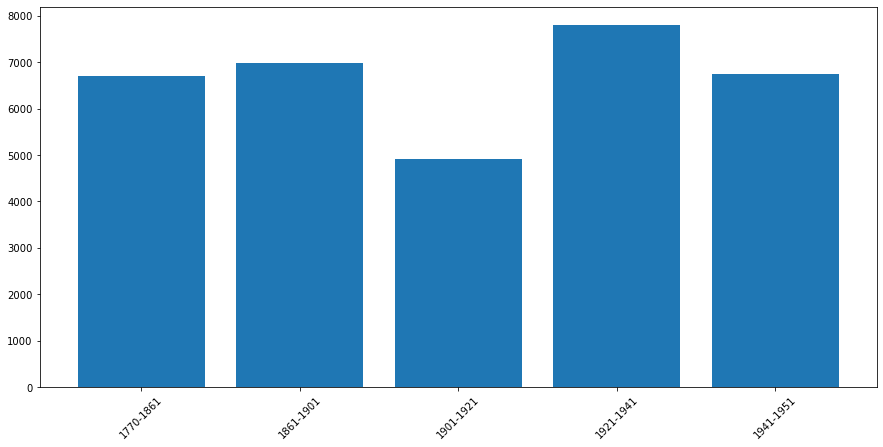

In [19]:
objects = [l for l in gb_period.index]
eff = [l for l in gb_period]

print(objects[:5])
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
a = plt.bar(objects, eff)

In [20]:
# Check the type of period or transform as string 
df_educ['period'] = df_educ['period'].astype(str)

In [235]:
# Group by site of study and count the number of individuals per period
gb_period_uni = df_educ.groupby(['educatedAt','long','lat', 'period']).agg({'year': 'count'}).reset_index()
gb_period_uni = gb_period_uni.rename(columns={'year': 'frequency'})
gb_period_uni.head()

,educatedAt,long,lat,period,frequency
0,A. H. Parker High School,-86.83060,33.514700,1921-1941,1
1,A.C. Davis High School,-118.32900,40.806944,1861-1901,1
2,Aalborg Cathedral School,9.91139,57.048100,1921-1941,2
3,Aalborg Cathedral School,9.91139,57.048100,1941-1951,1
4,Aalborg University,9.98500,57.015000,1941-1951,1


In [236]:
# Save the dataframe
gb_period_uni.to_csv('maps/birth_place_educatedAt.csv', sep='|')

## **Create maps**

In [237]:
# Choose basemap
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(layers=(open_street_map,watercolor,esri_sat), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=False    # , zoom=4, scroll_wheel_zoom= True
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m1, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m1.add_control(widget_control1)

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

m1

Map(center=[35, 5], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

## **Add the layer with the universities**

In [238]:
## Count individuals per universities and period
gb_count_uni = df_educ.groupby(['educatedAt','long','lat']).agg({'year': 'count'}).reset_index()
gb_count_uni = gb_count_uni.rename(columns={'year': 'frequency'})
gb_period_uni.head()

,educatedAt,long,lat,period,frequency
0,A. H. Parker High School,-86.83060,33.514700,1921-1941,1
1,A.C. Davis High School,-118.32900,40.806944,1861-1901,1
2,Aalborg Cathedral School,9.91139,57.048100,1921-1941,2
3,Aalborg Cathedral School,9.91139,57.048100,1941-1951,1
4,Aalborg University,9.98500,57.015000,1941-1951,1


In [239]:
gb_period_uni["period"]=gb_period_uni["period"].astype(str)

In [240]:
# Browse the dataframe and extract values
markers = []
for i,v in gb_count_uni.iterrows():
    marker = Marker(location=(v['lat'], v['long']), draggable=False,\
                    title=  v['educatedAt'] + ' (' + str(v['frequency']) + ')' )
                    
    
    markers.append(marker)

print("Markers' number " + str(len(markers)))

lg2 = MarkerCluster(name='Universities', markers=markers)

m1.add_layer(lg2)

Markers' number 7785


In [ ]:
### Save and display in HTML format 
## Notice the interactivity doesn't work
## Open the file in a browser 
m1.save('maps/birth_place_educatedAt.html', title='Universities')

**Comments**: it is possible to combine the universities and persons layers. But this uses a lot of ressources. 

## **Maps with polygone**

Now, another method to realize maps is proposed. This one is less interactive, than the previous one, but it permits more to visualize the data.

In [21]:
# import a dataframe with the polygon of the world's countries from geopandas
# A polygon permits to have the outlines of an object
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [22]:
 world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [23]:
# Keep only the colums intresting
world = world[['continent', 'geometry']]
# Dissolve function aggregate the polygon from country to continent 
# cf. https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html?highlight=dissolve
continents_w = world.dissolve(by='continent')

In [24]:
continents_w

,geometry
continent,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...
Antarctica,(POLYGON ((-159.2081835601977 -79.497059421708...
Asia,(POLYGON ((120.7156087586305 -10.2395813940878...
Europe,(POLYGON ((-52.55642473001839 2.50470530843705...
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
Oceania,(POLYGON ((173.0203747907408 -40.9190524228564...
Seven seas (open ocean),"POLYGON ((68.935 -48.62500000000001, 69.58 -48..."
South America,(POLYGON ((-68.63401022758316 -52.636370458874...


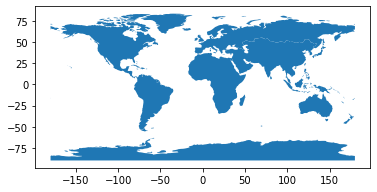

In [25]:
# Apply a maps of the continents
continents_w.plot();

In [27]:
# Merge polygon with a dataset previously used
continent=pd.read_csv("spreadsheets/Maps/continent_map.csv", sep="|")
continents=pd.merge(continent,continents_w, on='continent', sort=False).reset_index()
continents

,index,uri_entity,year,nationality,continent,geometry
0,0,urn:uuid:fb3527da-478c-4e4f-a861-9de00b9d154b,1959,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
1,1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
2,2,urn:uuid:98651569-7301-4398-a760-bcb03931dc0f,1955,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
3,3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
4,4,urn:uuid:f967d755-8e28-4729-9966-1aa3e0bdba98,1827,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
...,...,...,...,...,...,...
110358,110358,urn:uuid:bc2bef0b-434e-44d2-b42e-b25bcb069724,1961,Barbados,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110359,110359,urn:uuid:0e82b54f-c7aa-4f78-8d87-351a45c79646,1837,Panama State,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110360,110360,urn:uuid:53602670-a356-4fa0-b273-2ad2e750a3f0,1924,Q8770091,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110361,110361,urn:uuid:fce2d4e8-7b44-439c-8570-75bae75f9a87,1958,Aruba,South America,(POLYGON ((-68.63401022758316 -52.636370458874...


In [28]:
# drop people after 1950  (because the number of individuals after 1950 decreases strongly,
# it is very probably a biais on the datas does not enter in Wikidata yet)
continents=continents[continents["year"] < 1950]
continents

,index,uri_entity,year,nationality,continent,geometry
1,1,urn:uuid:41ad1b0e-5f5e-43b6-9137-ea5f6bfe3cf4,1927,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
3,3,urn:uuid:080c5cc7-c62c-46ec-b0e9-0b98b6adc235,1927,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
4,4,urn:uuid:f967d755-8e28-4729-9966-1aa3e0bdba98,1827,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
5,5,urn:uuid:50628dbc-50cd-4fd7-93f6-a444c2dac636,1860,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
6,6,urn:uuid:d5e86bba-4821-421e-9706-438a58c978a3,1873,Canada,North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1..."
...,...,...,...,...,...,...
110355,110355,urn:uuid:59c5f1e8-c8d3-4009-b496-a5dc3fdab1ed,1838,Barbados,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110356,110356,urn:uuid:0b09a04b-0f51-470b-89aa-556077f8caad,1921,Barbados,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110357,110357,urn:uuid:ca2d5779-6163-4154-b214-daccbd093ce5,1949,Barbados,South America,(POLYGON ((-68.63401022758316 -52.636370458874...
110359,110359,urn:uuid:0e82b54f-c7aa-4f78-8d87-351a45c79646,1837,Panama State,South America,(POLYGON ((-68.63401022758316 -52.636370458874...


In [29]:
# Slice dataframe into several dataframes by period
continents_1770_1861=continents[continents["year"] <= 1861]
continents_1861_1901=continents[(continents["year"] > 1861) & (continents["year"] <= 1901)]
continents_1901_1921=continents[(continents["year"] > 1901) & (continents["year"] <= 1921)]
continents_1921_1941=continents[(continents["year"] > 1821) & (continents["year"] <= 1941)]
continents_1941_1950=continents[(continents["year"] > 1941) & (continents["year"] <= 1950)]

In [30]:
# Group the row by continent
gb_cont_1770_1861 = continents_1770_1861.groupby(['continent']).size()
gb_cont_1861_1901 = continents_1861_1901.groupby(['continent']).size()
gb_cont_1901_1921 = continents_1901_1921.groupby(['continent']).size()
gb_cont_1921_1941 = continents_1921_1941.groupby(['continent']).size()
gb_cont_1941_1950 = continents_1941_1950.groupby(['continent']).size()

In [31]:
# Add a column 'frequency'
gb_cont_1770_1861 = gb_cont_1770_1861.to_frame()
gb_cont_1770_1861.columns = ['frequency']
gb_cont_1861_1901 = gb_cont_1861_1901.to_frame()
gb_cont_1861_1901.columns = ['frequency']
gb_cont_1901_1921 = gb_cont_1901_1921.to_frame()
gb_cont_1901_1921.columns = ['frequency']
gb_cont_1921_1941 = gb_cont_1921_1941.to_frame()
gb_cont_1921_1941.columns = ['frequency']
gb_cont_1941_1950 = gb_cont_1941_1950.to_frame()
gb_cont_1941_1950.columns = ['frequency']

In [32]:
gb_cont_1941_1950

,frequency
continent,
Africa,278
Asia,1688
Europe,5430
North America,2429
Oceania,211
South America,96


In [33]:
# Merge each dataframe with polygon
pd_cont_1770_1861=pd.merge(gb_cont_1770_1861,continents_w, on='continent', sort=False).reset_index()
pd_cont_1861_1901=pd.merge(gb_cont_1861_1901,continents_w, on='continent', sort=False).reset_index()
pd_cont_1901_1921=pd.merge(gb_cont_1901_1921,continents_w, on='continent', sort=False).reset_index()
pd_cont_1921_1941=pd.merge(gb_cont_1921_1941,continents_w, on='continent', sort=False).reset_index()
pd_cont_1941_1950=pd.merge(gb_cont_1941_1950,continents_w, on='continent', sort=False).reset_index()

In [34]:
# It is necessary to use the 'GeoDataFrame' function to the dataframes are well understood by Geopandas
pd_cont_1770_1861=  gpd.GeoDataFrame(pd_cont_1770_1861)
pd_cont_1861_1901=  gpd.GeoDataFrame(pd_cont_1861_1901)
pd_cont_1901_1921=  gpd.GeoDataFrame(pd_cont_1901_1921)
pd_cont_1921_1941=  gpd.GeoDataFrame(pd_cont_1921_1941)
pd_cont_1941_1950=  gpd.GeoDataFrame(pd_cont_1941_1950)

In [35]:
# Keep only the number of individuals. We will use them on the maps later.
frequency_1770_1861=pd_cont_1770_1861['frequency']
frequency_1861_1901=pd_cont_1861_1901['frequency']
frequency_1901_1921=pd_cont_1901_1921['frequency']
frequency_1921_1941=pd_cont_1921_1941['frequency']
frequency_1941_1950=pd_cont_1941_1950['frequency']

In [36]:
# Calculate the percentage of individuals for each period
perc_1770_1861= (frequency_1770_1861 / frequency_1770_1861.sum()) * 100
perc_1861_1901= (frequency_1861_1901 / frequency_1861_1901.sum()) * 100
perc_1901_1921= (frequency_1901_1921 / frequency_1901_1921.sum()) * 100
perc_1921_1941= (frequency_1921_1941 / frequency_1921_1941.sum()) * 100
perc_1941_1950= (frequency_1941_1950 / frequency_1941_1950.sum()) * 100

In [37]:
# The settings are used to set the number minimum and maximum and keep the same for each map. 
vmin=2000
vmin_per=0
vmax=12000
vmax_per=100

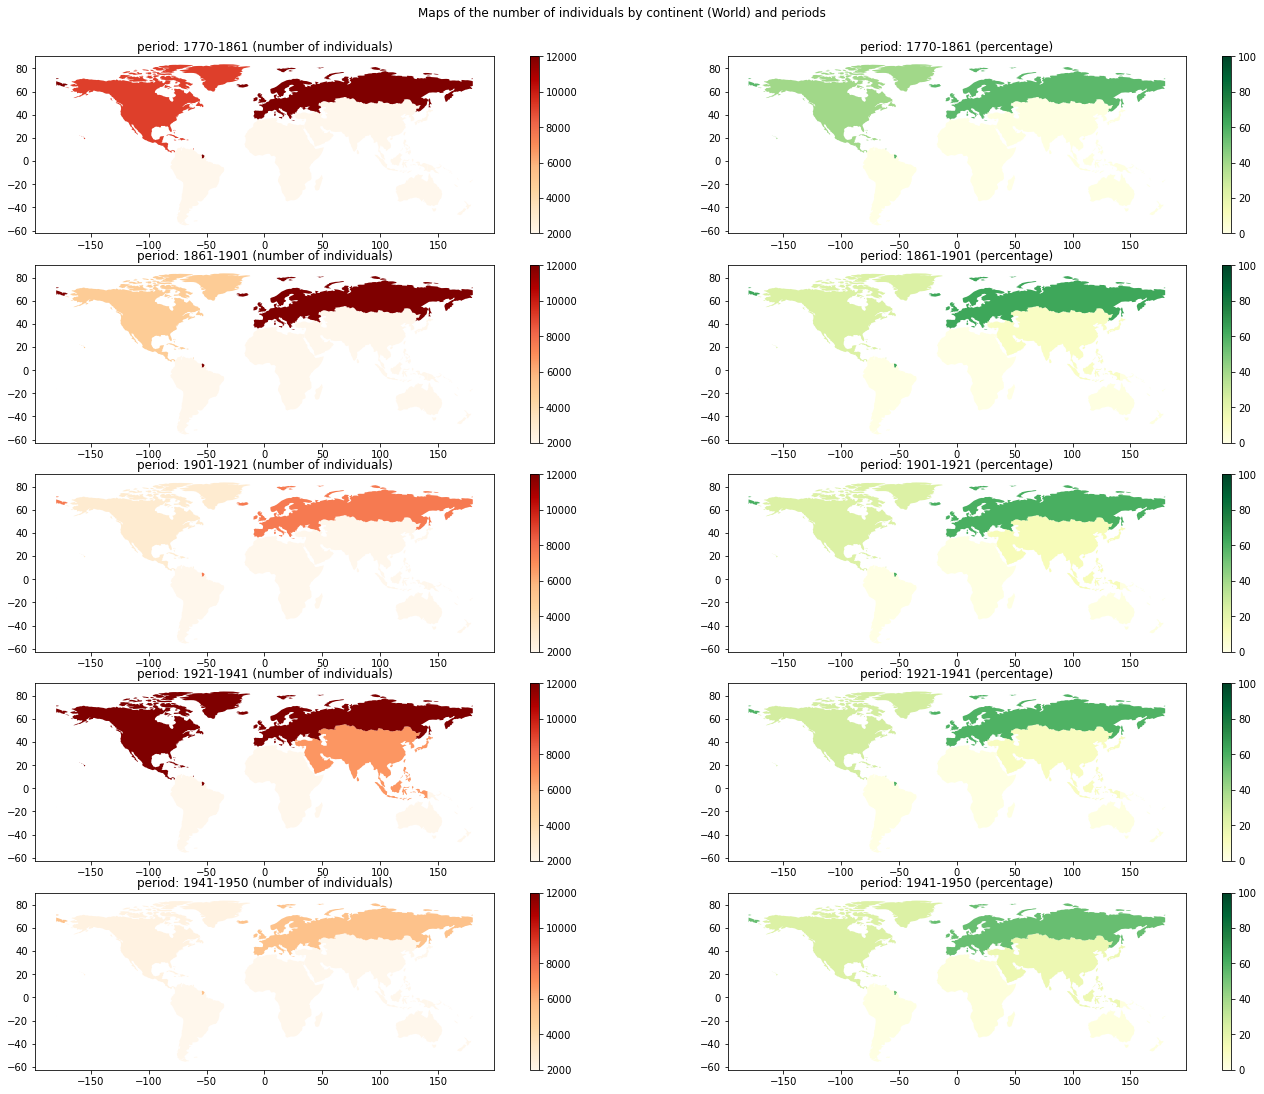

In [39]:
# display the maps
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(
                                    ncols=2,
                                    nrows=5,
                                    figsize=(20, 15))

fig.suptitle(x=0.50,y=1.01, t='Maps of the number of individuals by continent (World) and periods')

pd_cont_1770_1861.plot(column=frequency_1770_1861, ax=ax1, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax)
pd_cont_1770_1861.plot(column=perc_1770_1861,      ax=ax2, cmap='YlGn', legend=True, vmin=vmin_per, vmax=vmax_per)
pd_cont_1861_1901.plot(column=frequency_1861_1901, ax=ax3, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax)
pd_cont_1861_1901.plot(column=perc_1861_1901,      ax=ax4, cmap='YlGn', legend=True, vmin=vmin_per, vmax=vmax_per)
pd_cont_1901_1921.plot(column=frequency_1901_1921, ax=ax5, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax)
pd_cont_1901_1921.plot(column=perc_1901_1921,      ax=ax6, cmap='YlGn', legend=True, vmin=vmin_per, vmax=vmax_per)
pd_cont_1921_1941.plot(column=frequency_1921_1941, ax=ax7, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax)
pd_cont_1921_1941.plot(column=perc_1921_1941,      ax=ax8, cmap='YlGn', legend=True, vmin=vmin_per, vmax=vmax_per)
pd_cont_1941_1950.plot(column=frequency_1941_1950, ax=ax9, cmap='OrRd', legend=True, vmin=vmin, vmax=vmax)
pd_cont_1941_1950.plot(column=perc_1941_1950,      ax=ax10, cmap='YlGn', legend=True, vmin=vmin_per, vmax=vmax_per)

plt.tight_layout()

ax1.set_title('period: 1770-1861 (number of individuals)')
ax2.set_title('period: 1770-1861 (percentage)')
ax3.set_title('period: 1861-1901 (number of individuals)')
ax4.set_title('period: 1861-1901 (percentage)')
ax5.set_title('period: 1901-1921 (number of individuals)')
ax6.set_title('period: 1901-1921 (percentage)')
ax7.set_title('period: 1921-1941 (number of individuals)')
ax8.set_title('period: 1921-1941 (percentage)')
ax9.set_title('period: 1941-1950 (number of individuals)')
ax10.set_title('period: 1941-1950 (percentage)')

plt.show()

**Comments**: This method uses lew resources compared to the previous one. This is the advantage to see better the number of individuals globally. Conversely, the individuals disappear. Unfortunalty, we can't find polygon for European europe. Another way to realise it, it will be to create the geographical points for each region. 